In [2]:
import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/dlia_course/practical_sessions/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/dlia_course/practical_sessions


# Simple neural net tutorial

In this notebook, we will program a 2 layer neural network. It will classify two dimensional data into two classes.

https://drive.google.com/file/d/15TxpWNTfoF_UDDby0rToZZ9C_Du6jcZd/view?usp=sharing

The first layer will contain $q$ neurons and the second one $r$. Thus:

- $\mathbf{x}$ is a vector containing two elements;
- $\mathbf{W}_1$ is a matrix of size $(q, 2)$ and $\mathbf{b}_1$ a vector of size $q$;
- $\mathbf{W}_2$ is a matrix of size $(r, 2)$ and $\mathbf{b}_2$ a vector of size $r$.

Here $r=1$. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Magic used by the notebook to show figures inline
%matplotlib inline
# matplotlib default values
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading packages
%load_ext autoreload
%autoreload 2

random_seed = 4

import sys
print("Python version:", sys.version)

Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


## Data for classification problems

The data below correspond to classification problems. Each input dataset $\mathbf{X}$ contains points of $\mathbb{R}^2$. The output datasets $\mathbf{y}$ give one of two classes, coded as $0$ or $1$, to each point.


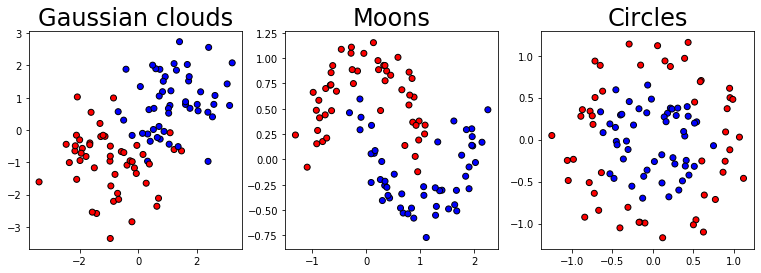

In [4]:
# Load and display data
from sklearn.datasets import make_moons, make_circles, make_blobs

figure = plt.figure(figsize=(13, 4))
cm = plt.cm.RdBu
cm_red_blue = ListedColormap(['#FF0000', '#0000FF'])

# Linearly separable
X_lin, y_lin = make_blobs(n_features=2, random_state=random_seed, centers=[[-1, -1], [1, 1]])
ax = plt.subplot(1, 3, 1)
ax.set_title("Gaussian clouds", fontsize=24)
ax.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap=cm_red_blue,
               edgecolors='k')

# Moons
X_moons, y_moons = make_moons(noise=0.15, random_state=random_seed)
ax = plt.subplot(1, 3, 2)
ax.set_title("Moons", fontsize=24)
ax.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cm_red_blue,
               edgecolors='k')

# Circles (factor: ratio between inner and outer circles radius)
X_circ, y_circ = make_circles(noise=0.15, factor=0.5, random_state=random_seed)
ax = plt.subplot(1, 3, 3)
ax.set_title("Circles", fontsize=24)
ax.scatter(X_circ[:, 0], X_circ[:, 1], c=y_circ, cmap=cm_red_blue,
               edgecolors='k')

datasets = {"lin": [X_lin, y_lin], "circ": [X_circ, y_circ], "moons": [X_moons, y_moons]}

plt.show()
   

In [0]:
# Chosing the data set that will be used in the following
my_set = "moons"  # can be any of "lin", "circ" or "moons"
X_sel = datasets[my_set][0]
y_sel = datasets[my_set][1]


## A simple two-layer Neural Network

The simple two-layer Neural Network we are going to implement here, will implement the following functions:

\begin{eqnarray}
t_1 &=& b_1 + W_1 x \\
y_1 &=& g_1(t_1) \\
t_2 &=& b_2 + W_2 x \\
y_2 &=& g_2(t_2) \\
\end{eqnarray}

**Assignment**: Below you will find an incomplete implementation of this network. Complete the implementation by replacing the `None` by the correct expressions at the indicated places (indication by `TODO`). Do not change the `__init__`. 

Tip: remember that the gradient has always the same dimension as the variable. 

Tip: when you implement the backpropagation, you will need to calculate the derivative $\frac{\partial t}{\partial W}$. Think about how to write this mathematically prior to implementing it. 


In [0]:
class SimpleNeuralNet(object):
    """Two-layer neural network, with two inputs and one output.
    """
    
    def __init__(self, q, r, act1, act2, random_state=None, sigma=0.01):
        """Neural network initialization.
        
        Arguments:
           q, r: number of neurons in the each layer.
           act1, act2: classes from activations.py used to instantiate the first and second activations.
           random_state: any real value. None means that no random seed is given.
           sigma: standard deviation of the normal random variable used for initializing the weights
           
        Returns:
            None
        """
        np.random.seed(random_state)
        self.sigma = sigma
        self.activation1 = act1()
        self.activation2 = act2()

        # number of neurons in the hidden layer
        self.q = q

        # number of neurons in the output layer
        # Here we can fix this to 1.
        self.r = 1

        self.initialize_parameters()

        self.dl_dy2 = None
        self.dl_dt2 = None
        self.dl_dW2 = None
        self.dl_db2 = None
        self.dl_dy1 = None
        self.dl_dt1 = None
        self.dl_dW1 = None
        self.dl_db1 = None

    def initialize_parameters(self):
        self.W1 = np.random.randn(self.q, 2) * self.sigma
        self.b1 = np.random.rand(self.q)
        self.W2 = np.random.randn(self.r, self.q) * self.sigma
        self.b2 = np.random.rand(self.r)
        return 

    def predict(self, x):
        """Compute NN prediction.
        
        x: numpy array containing 2 elements or a batch of samples. 
        """
        # x can be either a vector or a matrix (batch)
        # For this, we need to broadcast the b vector. 
        t1 = np.matmul(self.W1, x) + self.b1[:,np.newaxis]
        y1 = self.activation1(t1)
        t2 = np.matmul(self.W2, y1) + self.b2[:,np.newaxis]
        y2 = self.activation2(t2)

        return y2
    
    def forward_back_propagation(self, x, y_gt, verbose=False):
        """Forward pass, backward pass with parameters update, on a single sample.
        
        x: numpy array containing a single training sample (two coordinates).
        y_gt: expected output (ground-truth).
        verbose: toggles verbose mode
        
        Returns:
        L: loss value for the given input (before back propagation)
        """
        # Compute forward pass and local gradients
        # TODO : write the gradients
        t1 = np.matmul(self.W1, x) + self.b1
        dt1_dW1_transp = None
        dt1_db1 = None
        # end of your code

        y1 = self.activation1(t1)
        dy1_dt1 = self.activation1.grad(t1)
        
        t2 = np.matmul(self.W2, y1) + self.b2
        # TODO : write the gradients
        dt2_dy1 = None
        dt2_dW2_transp = None
        dt2_db2 = None
        # end of your code

        y2 = self.activation2(t2)
        dy2_dt2 = self.activation2.grad(t2)
        
        L = np.square(y2 - y_gt).sum()
        if verbose is True: print("Predicted output (y): ", y)
        
        # Back propagate gradient
        # TODO : write the gradients
        self.dl_dy2 = None
        self.dl_dt2 = None
        self.dl_dW2 = None
        self.dl_db2 = None
        self.dl_dy1 = None
        self.dl_dt1 = None
        self.dl_dW1 = None
        self.dl_db1 = None
        # end of your code

        return L
    
    def update_parameters(self, learning_rate): 
        # TODO: Update parameters (gradient descent)
        # end of your code
        return

    def fit(self, X, Y, epochs, learning_rate, verbose=False):
        """Learn model using gradient descent.
        
        X: input examples
        Y: output examples
        learning_rate: learning rate
        verbose: toggle verbose mode
        """
        loss_hist = []
        for epoch in range(epochs):
            epoch_loss_list = []
            for (x, y) in zip(X, Y):
                epoch_loss_list += [self.forward_back_propagation(x, y)]
                self.update_parameters(learning_rate)
            if verbose is True: print("Epoch ", epoch, " : loss = ", np.mean(epoch_loss_list))
            loss_hist += [np.mean(epoch_loss_list)]
                
        return loss_hist


In [0]:
from dlia_tools import activations

act1 = activations.ActivationRelu
act2 = activations.ActivationRelu

q = 8
r = 1

nn = SimpleNeuralNet(q, r, act1, act2, random_state=random_seed)

We will now train the Neural Network (single epoch) and plot the results. 

In [0]:
# Create grid for visualization
h = 0.1
x0_min = X_sel[:, 0].min() - h
x0_max = X_sel[:, 0].max() + h
x1_min = X_sel[:, 1].min() - h
x1_max = X_sel[:, 1].max() + h
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h), np.arange(x1_min, x1_max, h))
xx0_ravel = xx0.ravel()
xx1_ravel = xx1.ravel()

# we initialize the parameters (in case you come back to this cell several times)
nn.initialize_parameters()

# Train a single epoch - look at the evolution of the model
loss = []
learning_rate = 0.1
for (x, y) in zip(X_sel, y_sel):
    loss += [nn.forward_back_propagation(x, y)]
    nn.update_parameters(learning_rate)

# predict on all grid points
x_grid = np.vstack([xx0_ravel, xx1_ravel])
y_pred_ravel = nn.predict(x_grid)
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.set_xlim((np.min(xx0),np.max(xx0)))
ax.set_ylim((np.min(xx1),np.max(xx1)))
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue,
               edgecolors='k')
plt.show()

We will now train the neural network on several epochs. We will use Stochastic Gradient descent (no batches). 

In [0]:
nn = SimpleNeuralNet(q, 1, act1, act2, random_state=random_seed)

# Train N epochs
epochs = 200
learning_rate = 0.1
loss_hist = nn.fit(X_sel, y_sel, epochs, learning_rate)
print("Final loss: ", loss_hist[-1])

# predict on all grid points
x_grid = np.vstack([xx0_ravel, xx1_ravel])
y_pred_ravel = nn.predict(x_grid)
y_pred = y_pred_ravel.reshape(xx0.shape)

# Plot current model
figure = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("Current prediction")
ax.contourf(xx0, xx1, y_pred, cmap=cm, alpha=.8)
ax.scatter(X_sel[:, 0], X_sel[:, 1], c=y_sel, cmap=cm_red_blue, edgecolors='k')
ax.set_xlim((np.min(xx0),np.max(xx0)))
ax.set_ylim((np.min(xx1),np.max(xx1)))
plt.show()

In [0]:
figure = plt.figure(figsize=(6, 6))
plt.plot(loss_hist)
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.show()

**Assignment**: Test the Neural Network for the datasets `moon` and `circ`. The input of the network is limited to 2 dimensions. 